In [1]:
import os
import math
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Opdracht 2: Bepalen van tumoren in MRI-scans¶
## Inleiding
In de eerste opdracht van deze casus hebben we een artificeel neuraal netwerk gemaakt dat in staat was om afbeeldingen van kledingstukken te klassificeren. Een vergelijkbare techniek kun je toepassen op medische beelden, bijvoorbeeld resultaten van een MRI-scan.

Tijdens deze opdracht wordt je gevraagd precies dit te doen. Aan de hand van een set coupures van MRI-scans van geïnfecteerd borstweefsel kun je een model trainen dat van een nieuwe coupure kan voorspellen of het geïnfecteerd of schoon weefsel betreft. Tijdens het plenaire deel wordt de vorm van deze data toegelicht; de besproken notebook vind je hier.

##  Opdracht
We gaan werken aan het opsporen van Invasief ductaal carcinoom (Invasive ductal carcinoma, IDC). De oorspronkelijke dataset bestond uit 279 scans van borsten met en dergelijk carcicoom. Van deze oorspronkelijke data zijn 277.524 uitsneden gemaakt: 198.738 IDC-negatief and 78.786 IDC positief.

Je vindt de dataset op assemblix:/data/datasets/thema10/idc_regular.zip (de oorspronkelijke set vind je hier). Elke patiënt heeft z'n eigen directory die genoemd is naar het patiëntnummer. In deze directories vind je telkens weer twee andere directories: 0 en 1 met hierin de uiteindelijke uitsneden. De namen van al deze plaatjes hebben hetzelfde algemene formaat:

```<patiennr>_idx5_<x-coord>_<y_coord>_class[01].png```

De uitsneden die in de klasse 0 zitten betreffen gezond weefsel, de uitsneden in de directory 1 bevatten (delen van) tumoren. De bedoeling van deze opdracht is om een netwerk te creëren dat in staat is het gezonde van het ongezonde weefsteld te onderscheiden.

### deel 1: data-analyse

Zoals altijd in een dergelijk project beginnen we met het analyseren van de data. Maak een Notebook met een exporatieve data-analyse. Beantwoord hierin (zowel schriftelijk als met afbeeldingen) in ieder geval de volgende vragen:

* Heb je missende waarden in de dataset?
* Hoeveel uitsneden van gezond en van ongezond weefsel hebben we en wat is de verhouding tussen deze twee?
* Welk percentage van de totale scan is ongezond weefsel? Laat dit zien per patiënt en ten opzichte van het gemiddelde.
* Welke gebieden van de totale scan (x-y-coördinaten) worden het meest geïnfecteerd met IDC? Kun je op basis van dit gegeven iets zeggen over de tumoren?

Toon tevens een aantal (bijvoorbeeld zestien) uitsneden van zowel gezond als ongezond weefsel. Kun je op basis van deze visualisaties iets zeggen over het verschil?

Kun je zelf nog andere interessante statistieken uit deze dataset halen?



In [2]:
# Functie om de filenamen uit de patient te extraheren
def get_img_filenames(patient_id):
    imgs_positive = []
    imgs_negative = []
    imgs_negative.extend(os.listdir(f'{patient_id}/0/'))
    imgs_positive.extend(os.listdir(f'{patient_id}/1/'))
    return imgs_positive, imgs_negative

patient_id = 'data/idc_regular/10272'

img_positive, img_negative = get_img_filenames(patient_id)
print(patient_id)
print(f"Positive: {len(img_positive)}")
print(f"Negative: {len(img_negative)}")
print(f"Total: {len(img_positive) + len(img_negative)}")

patient_id = 'data/idc_regular/10273'

img_positive, img_negative = get_img_filenames(patient_id)
print(patient_id)
print(f"Positive: {len(img_positive)}")
print(f"Negative: {len(img_negative)}")
print(f"Total: {len(img_positive) + len(img_negative)}")


data/idc_regular/10272
Positive: 25
Negative: 2150
Total: 2175
data/idc_regular/10273
Positive: 1211
Negative: 811
Total: 2022


Er is een verschil in img snippets. Wel verwacht en ook logisch. Maar het kan ook wel een invloed hebben wanneer de hoeveelheid aanzienlijk meer zwart behoud wanneer het plaatje weer in elkaar wordt gezet. Dit kan in de toekomst mogelijk classificatie verschillen opleveren.

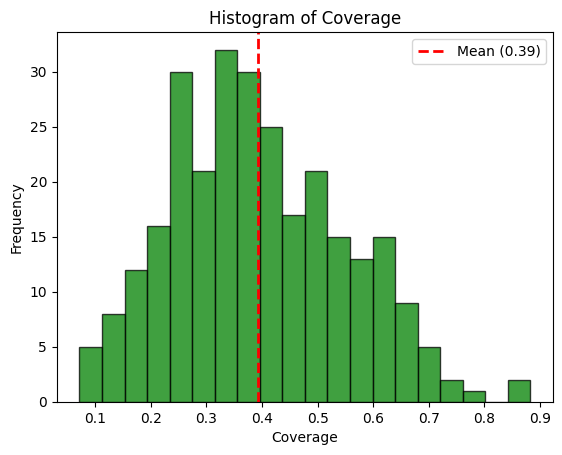

In [3]:
# bepaald de xlen en ylen van een complete img op basis van de namen
def get_total_img_size(img_name_list):
    x_min = math.inf
    x_max = -math.inf
    y_min = math.inf
    y_max = -math.inf

    for img in img_name_list:
        img = img.split('_')
        x =  int(img[2].strip("x"))
        if x < x_min :
            x_min = x
        if x > x_max:
            x_max = x

        y = int(img[3].strip("y"))
        if y < y_min :
            y_min = y
        if y > y_max:
            y_max = y

    return  x_max - x_min, y_max - y_min

# bepaald het percentage van de plaatjes die samen heel maken
def get_coverage(patient_id):
    imgs_positive, imgs_negative = get_img_filenames(patient_id)
    img_total = imgs_positive + imgs_negative

    x_len, y_len = get_total_img_size(img_total)
    area = x_len * y_len / 2500 # pixel correction
    coverage = len(img_total)/area
    return coverage

img_file_names = []
data_dir = "data/idc_regular/"
img_file_names.extend([f"{data_dir}{i}"for i in os.listdir(data_dir)])
cov = [get_coverage(patient_id) for patient_id in img_file_names]
mean = sum(cov) / len(cov)

plt.hist(cov, bins=20, edgecolor="black", color="g", alpha=0.75)
plt.axvline(x=mean, color="red", linestyle="--", linewidth=2, label=f"Mean ({mean:.2f})")
plt.title("Histogram of Coverage")
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Veel zijn voornamelijk empty, maar dat is voor nu nog geen probleem. Nu kijken hoe het zit met de verhuidingen tussen positief en negatief.

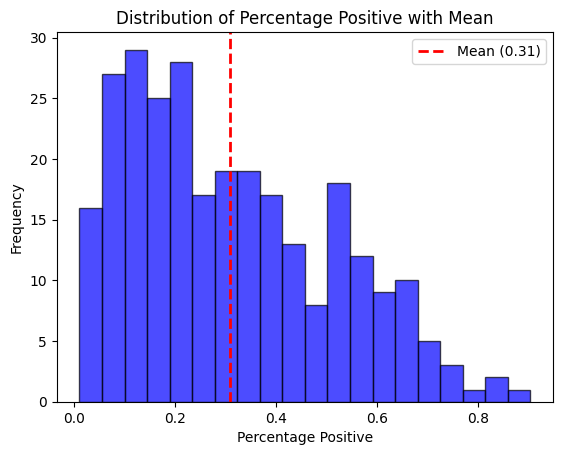

In [4]:
# kijkt hoeveel van het totale bekendheid positief is
def get_percentage_positive(patient_id):
    imgs_positive, imgs_negative = get_img_filenames(patient_id)
    total_imgs = len(imgs_positive) + len(imgs_negative)
    return len(imgs_positive) / total_imgs

percentage_positive = [get_percentage_positive(patient_id) for patient_id in img_file_names]
mean=sum(percentage_positive) / len(percentage_positive)

plt.hist(percentage_positive, bins=20, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(x=mean, color="red", linestyle="--", linewidth=2, label=f"Mean ({mean:.2f})")
plt.xlabel("Percentage Positive")
plt.ylabel("Frequency")
plt.title("Distribution of Percentage Positive with Mean")
plt.legend()

Met een gemiddelde van `0.31` is het in principe is dit ook niet heel verkeerd. Dit is tenopzichte van de totale hoeveelheid positief en negatief maar niet de totale oppervlakte van het geheel (inclusief zwart). dit kan ook nog wel interessant zijn om naar te kijken.

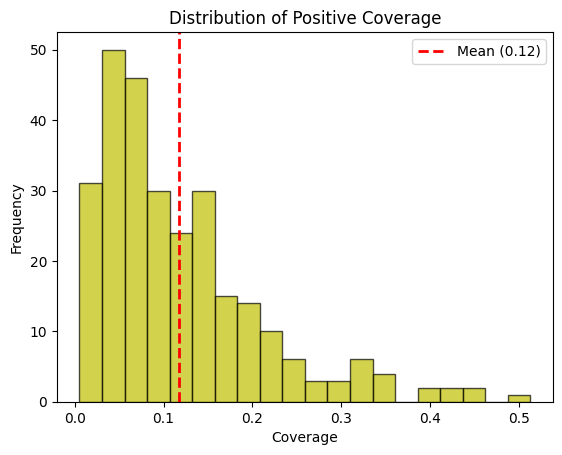

In [5]:
# bepaald het percentage positief over het hele plaatje (ook inclusief zwart)
def get_positive_coverage(patient_id):
    imgs_positive, imgs_negative = get_img_filenames(patient_id)
    img_total = imgs_positive + imgs_negative

    x_len, y_len = get_total_img_size(img_total)
    area = x_len * y_len / 2500 # pixel correction
    positive_coverage = len(imgs_positive)/area
    return positive_coverage

positive_coverage = [get_positive_coverage(patient_id) for patient_id in img_file_names]
mean=sum(positive_coverage) / len(positive_coverage)
plt.hist(positive_coverage, bins=20, alpha=0.7, color="y", edgecolor="black")
plt.axvline(x=mean, color="red", linestyle="--", linewidth=2, label=f"Mean ({mean:.2f})")
plt.title("Distribution of Positive Coverage")
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Dat is niet heel veel. Maar niet afwijkend van wat de eerdere plots hebben laten zien. Het zou ongeveer 1/3 van 1/4 moeten zijn en dat komt overeen met een gemiddelde van `0.12`. Nu kijken welke regie het vaakst een tumor is.

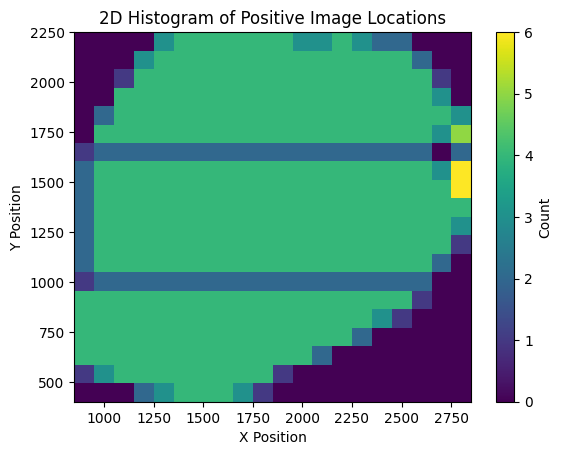

In [6]:
def get_locations(file_name_list):
    x_pos = []
    y_pos = []
    for file_name in file_name_list:
        file_name = file_name.split('_')
        x_pos.append(int(file_name[2].strip("x")))
        y_pos.append(int(file_name[3].strip("y")))
    return x_pos, y_pos

positive_x_pos, positive_y_pos = get_locations(img_positive)

plt.hist2d(positive_x_pos, positive_y_pos, bins=(20,20))
plt.colorbar(label="Count")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("2D Histogram of Positive Image Locations")
plt.show()


In de hoeken word het minst vaak een tumor herkend. De hoogste dichtheid zit aan de rechterkant. Laten we nu kijken naar wat positieve plaatjes En daarna naar negatieve. kijken of er een duidelijk verschil tussen zit.

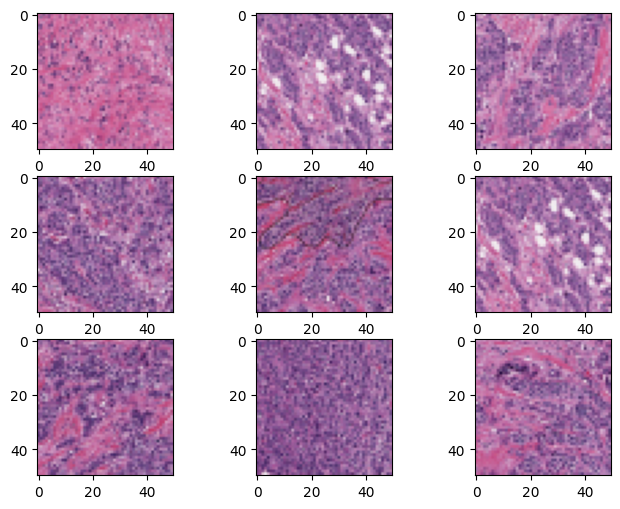

In [7]:
fig,ax = plt.subplots(3, 3, figsize = (8,6))

for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(img_positive))
        img = Image.open(f'{patient_id}/1/{img_positive[idx]}')
        ax[c, r].imshow(img, cmap='gray')

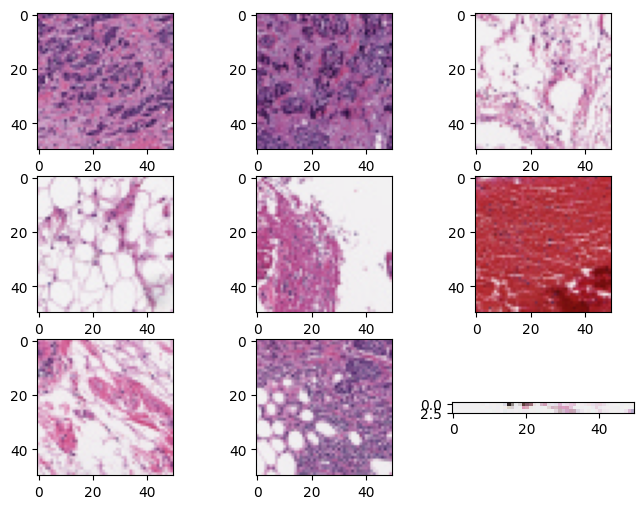

In [8]:
fig,ax = plt.subplots(3, 3, figsize = (8,6))

for r in range(3):
    for c in range(3):
        idx = np.random.choice(len(img_negative))
        img = Image.open(f'{patient_id}/0/{img_negative[idx]}')
        ax[c, r].imshow(img, cmap='gray')

Er is op het oog niet een verschil uit op te maken.

 ## deel 2: een model trainen

Maak nu een model dat is staat is uitsneden van gezond weefsel te onderscheiden van geïnfecteerd weefsel. Splits hiervoor de data (maak bijvoorbeeld gebruik van sklearn.train_test_split) – bedenk of je deze splitsing horizontaal (per patiënt een deel weghalen) of verticaal (een deel van de patiënten) uitvoert en beargumenteer waarom.

Probeer verschillende modellen en verschillende architecturen uit en vergelijk de resultaten met elkaar.

De goede strategie voor het splitsen van de data is horizontaal. Dit met de rede dat voor verticaal de cases (patienten) dan compleet los van elkaar zijn en de trainingsdata hierdoor volledig afgeschermd is van de testdata. Dat is niet perse wat we willen, dat is namelijk een antwoord over de hele dataset. Daarom is horizontaal de beste strategie. Alleen omdat dit zo'n gigantische dataset is halen we er en fractie tussenuit om mee tenemen in het trainen van onze modellen.

In [9]:
import numpy as np
import random
from PIL import Image

# Functie om afbeeldingen te laden en te preprocessen
def preprocess_images(image_paths, target_size=(50, 50)):
    data = []
    for path in image_paths:
        try:
            img = Image.open(path).convert("L")
            img_resized = img.resize(target_size)
            img_array = np.array(img_resized) / 255.0
            data.append(img_array.flatten())
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(data)

all_X = []
all_y = []
for patient_id in img_file_names:
    pos, neg = get_img_filenames(patient_id)
    all_X.append([f"{patient_id}/1/{img}" for img in pos])
    all_X.append([f"{patient_id}/0/{img}" for img in neg])

    all_y.append([1] * len(pos))
    all_y.append([0] * len(neg))

# Alle paden combineren en willekeurig sample
all_paths = list(zip(np.concatenate(all_X), np.concatenate(all_y)))
sample_size = int(len(all_paths) * 0.05)
sampled_paths = random.sample(all_paths, sample_size)

# Paden en labels splitsen
sampled_X = [path for path, _ in sampled_paths]
sampled_y = [label for _, label in sampled_paths]

# Laad de gesamplede afbeeldingen
X_sampled = preprocess_images(sampled_X)
y_sampled = np.array(sampled_y)

print(f"Sampled X shape: {X_sampled.shape}")
print(f"Sampled y shape: {y_sampled.shape}")

Sampled X shape: (13876, 2500)
Sampled y shape: (13876,)


Nu het inladen van de img gelukt is moeten we de dataset gaan splitsen.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)

Nu ik de data gesplit heb kan ik de volgende gaan uitproberen
*  Support Vector Machines (SVM)
*  Random Forest (RF)
*  Logistical Regression (LR)
*  k-Nearest Neighbors (KNN)

In [11]:
model_svm = SVC(kernel='rbf', C=1.0, random_state=42)
model_svm.fit(X_train, y_train)

# Evalueren
y_pred_svm = model_svm.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      2013
           1       0.61      0.47      0.53       763

    accuracy                           0.77      2776
   macro avg       0.71      0.68      0.69      2776
weighted avg       0.76      0.77      0.76      2776



In [12]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Evalueren
y_pred_rf = model_rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      2013
           1       0.62      0.48      0.55       763

    accuracy                           0.78      2776
   macro avg       0.72      0.69      0.70      2776
weighted avg       0.77      0.78      0.77      2776



In [13]:
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

# Evalueren
y_pred_lr = model_lr.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))



Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.82      2013
           1       0.49      0.40      0.44       763

    accuracy                           0.72      2776
   macro avg       0.64      0.62      0.63      2776
weighted avg       0.71      0.72      0.71      2776



In [16]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

# Evalueren
y_pred_knn = model_knn.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.96      0.84      2013
           1       0.57      0.14      0.22       763

    accuracy                           0.73      2776
   macro avg       0.66      0.55      0.53      2776
weighted avg       0.70      0.73      0.67      2776



In [17]:
# summary accuracy
print("Support Vector Machines accuracy:", accuracy_score(y_test, y_pred_svm))
print("Random Forest accuracy:", accuracy_score(y_test, y_pred_rf))
print("Logistical Regression accuracy:", accuracy_score(y_test, y_pred_lr))
print("k-Nearest Neighbors accuracy:", accuracy_score(y_test, y_pred_knn))

Support Vector Machines accuracy: 0.7701729106628242
Random Forest accuracy: 0.7784582132564841
Logistical Regression accuracy: 0.7226224783861671
k-Nearest Neighbors accuracy: 0.7337896253602305


De RF en SVM doen geven de beste resultaten. De andere zitten eronder en zijn dus minder goed. Het is mogelijk dat wanneer de sample-size veranderd dat dit ook verbeteringen (of verslechteringen) kan zorgen.